<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/two-dimensions/Two_dimensions_Kendama_change_Class_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### すること
2次元への修正 ←現在これに着手 \\
稲邑教授の実験条件に似るように変更 \\
↑特に試行回数と難易度調整部分 \\
グラフ描写の関数をもっと可変性のあるものにする。（例えば、欲しいグラフは似たようなものが多いから引数を変えるだけで目的のグラフを作れるようにするなど） \\
各難易度の試行で、ある成功率に到達しなければ変化しないようにした方がいいのではないか？ \\
list型をndarayに統一して行列の計算を簡易化する \\


## わかったこと
おそらくαとβの関係性において、３種類の場合がありえる \\
1.   α=βの場合：均衡が取れているので一般的な難易度調整のパラメータで良さげな結果が取れている
2.   α>βの場合：成功した時の方が効果が大きいため、他の人よりもやる気があり分散が小さくなる傾向がありそう
3.   α<βの場合：失敗した時の方が効果が大きいため、他の人よりもやる気がなく分散が大きくなる傾向がありそう

### 調整の比率について
α<βの場合、α:β=1:2の場合、何度調整は簡易化:困難化=3:1だと良いくらい \\






In [3]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [4]:
class Kendama():    #学習率、皿の移動割合、難易度調整の割合、難易度の初期値を格納
  def __init__(self, get_times): #get_timesはけん玉の総試行回数
    # self.alpha = alpha    #学習率
    # self.beta = beta    #学習率
    # self.a = a    #皿の移動割合
    # self.rt = rt    #難易度調整の割合
    # self.success_rate = success_rate #難易度調整を行う際の成功率の指標
    # self.fail_rate = fail_rate #難易度調整を行う際の失敗率の指標
    mu = [0, 0]
    sigma = [[1, 0], [0, 1]]
    # 2次元正規乱数をけん玉の総試行回数分生成
    self.B = np.random.multivariate_normal(mu, sigma, size=get_times)  #けん玉の落下データを格納する配列（locは平均、scaleは標準偏差、sizeは導かれる値の数）つまり各試行時のけん玉の落下位置

  def Nonajustment(self, r, alpha, beta, a): #難易度を調整しない場合の結果を表す関数
    dispersion = [[1**2, 1**2, 0]]     #被験者のやる気を表す分散を格納する配列
    p = [[0,0]]       #皿のガウス分布の平均値を格納する配列
    x = []        #皿の位置変化を格納する配列
    rate = [100]
    trial = 0
    success = 0
    for i in range(len(self.B)):
      x.append(i)
      mu = [p[i][0], p[i][1]]   #平均
      sigma = [[dispersion[i][0], dispersion[i][2]],[dispersion[i][2], dispersion[i][1]]]   #共分散行列
      D = np.random.multivariate_normal(mu, sigma, size=1) #皿の位置を表す変数
      D = D[0]
      if (self.B[i][0]-D[0])**2+(self.B[i][1]-D[1])**2 <= r**2:     #成功した時の分散の変化
        p.append(D)
        dispersion.append([x / alpha for x in dispersion[i]])

      else:       #失敗した時の分散の変化
        p.append(self.B[i])
        dispersion.append([x * beta for x in dispersion[i]])
    x.append(len(self.B))
    return x,p,dispersion

  def Ajustment(self, r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate): #難易度を調整した場合（半径を小さくするのみ）の結果を表す関数
    dispersion = [[1**2, 1**2, 0]]     #被験者のやる気を表す分散を格納する配列
    p = [[0,0]]       #皿のガウス分布の平均値を格納する配列
    # success_rate = 0.66 #難易度調整を行う際の成功率の指標
    # fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
    success = 0    #成功回数を表す変数
    trial = 0       #試行回数を表す変数
    x = []  #試行回数を格納
    R = []
    srate = [0]
    success = 0
    Abs_degree_failure = [0]
    R.append(r)
    for i in range(len(self.B)):
      trial += 1
      x.append(i)
      R.append(r)
      mu = [p[i][0], p[i][1]]   #平均
      sigma = [[dispersion[i][0], dispersion[i][2]],[dispersion[i][2], dispersion[i][1]]]   #共分散行列
      D = np.random.multivariate_normal(mu, sigma, size=1) #皿の位置を表す変数
      D = D[0] #1次元の配列ができているので取り出す作業
      abs_degree_failure = abs(np.sqrt((self.B[i][0] - D[0])**2+(self.B[i][1] - D[1])**2)) #皿の中心と落下位置の差（絶対値）
      # if abs_degree_failure <= 0:
      #    abs_degree_failure = 0
      Abs_degree_failure.append(abs_degree_failure)
      if (self.B[i][0]-D[0])**2+(self.B[i][1]-D[1])**2 <= r**2:     #成功した時の分散の変化
        p.append(p[i])
        dispersion.append([x / alpha for x in dispersion[i]])
        success += 1
        r -= rt_alpha #成功した時の難易度調整
        if r < 0.1:    #半径が０.1未満にならないようにするための処置
          r = 0.1
      else:       #失敗した時の分散の変化
        r += rt_beta #失敗した時の難易度調整※いらない場合はコメントアウトさせる
        if r > 3.1:    #半径が０.1未満にならないようにするための処置
          r = 3.1
        p.append(self.B[i])
        dispersion.append([x * beta for x in dispersion[i]])
      srate.append((success/(i+1))*100)
    x.append(len(self.B))
    return x,p,dispersion,R,Abs_degree_failure,srate



In [5]:
#A_min_listの要素数は[1or10,5,201]
class kendama(Kendama):
  def __init__(self, get_times):
    super().__init__(get_times)
    #各パラメータにおいての結果を格納
    self.A_min_average_list = []
    self.A_matrix = []

    # 難しい方から調整した場合の分散のデータを格納
    self.A_min_list = []

  def show_Non(self, r): #rはけん玉の半径を示す ←引数の変更が必要
    self.Non_r = []  # 各半径での変化を格納すための配列

    # 各半径の変化を計算
    for i in range(5, 35, 5):
        r = i / 10
        Non_x, Non_p, Non_dispersion = self.Nonajustment(r)
        Non = [Non_x, Non_p, Non_dispersion]
        self.Non_r.insert(len(self.Non_r), Non)

    # 各半径の変化を描画
    fig, axs = plt.subplots( 2, len(self.Non_r), figsize=(16, 2 * 3), dpi=100, sharey="row")
    fig.subplots_adjust(hspace=0.5)
    for i, (Non_x, Non_p, Non_dispersion) in enumerate(self.Non_r):
        axs[0, i].plot(Non_x, Non_p[0], color='r') #一旦x軸だけ表示しているが削除する
        axs[1, i].plot(Non_x, [item[0] for item in Non_dispersion], color='b')

        axs[0, i].set_title(f"r={0.5*(i+1)}, D")
        axs[1, i].set_title(f"r={0.5*(i+1)}, σ")

    for ax in axs.flat:
        ax.set_xlabel("t (times)")

    axs[0, 0].set_ylabel("D")

    axs[1, 0].set_ylabel('σ')

    plt.tight_layout()
    plt.savefig(f"Non_Ajustment.png")
    files.download(f'Non_Ajustment.png')
    plt.show()

  def show_Comparison(self, r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate): #調整している時としていない時の比較
    self.Non_r = []  # 各半径での変化を格納すための配列
    self.A_min_list = []
    Non_x, Non_p, Non_dispersion = self.Nonajustment(r, alpha, beta, a)
    Non = [Non_x, Non_p, Non_dispersion]
    self.Non_r.insert(len(self.Non_r), Non)
    A_x, A_p, A_dispersion, R, Abs_degree_failure,srate = self.Ajustment(r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
    self.A_min_list.append((A_x, A_p, A_dispersion, R, Abs_degree_failure,srate))

    plt.plot(self.Non_r[0][0], self.Non_r[0][2])
    plt.plot(self.A_min_list[0][0], self.A_min_list[0][2])
    plt.xlabel("Number of trials")
    plt.ylabel("σ^2")
    plt.tight_layout()
    plt.savefig(f"Comparison.png")
    files.download(f'Comparison.png')
    plt.show()
    self.A_min_average_list = []
    self.Non_r = []


  def make_ajustment_from_max_average(self, r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate):
    # 難しい方から調整した場合の分散のデータを格納
    self.A_min_list = []
    for i in range(1): #forのループ回数は一旦1回にしている
        A_x, A_p, A_dispersion, R, Abs_degree_failure, srate = self.Ajustment(r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
        self.A_min_list.append((A_x, A_p, A_dispersion, R, Abs_degree_failure, srate))

    self.A_min_list_np = np.array(self.A_min_list)
    self.A_min_average_list.append(np.mean(self.A_min_list_np, axis=0))


  def show_ajustment_from_max_average(self):

    # サブプロットの設定
    fig, axs = plt.subplots(3, len(self.A_min_average_list), figsize=(16, 2 * 3), sharey="row")

    # グラフのプロット
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average, srate) in enumerate(self.A_min_average_list):
        axs[0, i].plot(A_x_average, Abs_degree_failure_average, color='r')
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[1, i].plot(A_x_average, srate, color='b')
        axs[2, i].plot(A_x_average, R_average, color='g')
        axs[0, 1].set_ylim(0,10)
        axs[1, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials")
    axs[1, 0].set_ylabel('σ^2')
    plt.tight_layout()
    plt.show()
    #配列の初期化
    self.A_min_average_list = []

  def show_ajustment_from_max_average_integration(self): #複数のグラフを重ねて表示させるための関数
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average,srate) in enumerate(self.A_min_average_list):
        plt.plot(A_x_average, [item[0] for item in A_dispersion_average])
    plt.xlabel("Number of trials")
    plt.ylabel("σ^2")
    plt.tight_layout()
    plt.savefig(f"difference of change.png")
    files.download(f'difference of change.png')
    plt.show()
    self.A_min_average_list = []

  def show_ajustment_from_max(self, r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate):
    # 難しい方から調整した場合の分散のデータを格納
    self.A_min_list = []

    for i in range(5):
        A_x, A_p, A_dispersion, R, Abs_degree_failure,srate = self.Ajustment(r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
        self.A_min_list.append((A_x, A_p, A_dispersion, R, Abs_degree_failure,srate))

    # サブプロットの設定
    fig, axs = plt.subplots(3, len(self.A_min_list), figsize=(16, 2 * 3), sharey="row")

    # グラフのプロット
    for i, (A_x, A_p, A_dispersion, R, Abs_degree_failure,srate) in enumerate(self.A_min_list):
        axs[0, i].plot(A_x, Abs_degree_failure, color='r')
        # axs[1, i].plot(A_x, [item[0] for item in A_dispersion], color='b')
        axs[1, i].plot(A_x, srate, color='b')
        axs[2, i].plot(A_x, R, color='g')

        axs[0, i].set_title(f"mean (Trial {i+1})")
        axs[1, i].set_title(f"dispersion (Trial {i+1})")
        axs[2, i].set_title(f"r (Trial {i+1})")

    plt.tight_layout()
    plt.show()

  def make_ajustment_from_max_graph(self, r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate):
    # 難しい方から調整した場合の分散のデータを格納
    self.A_min_list = []
    for i in range(1): #forのループ回数は一旦1回にしている
        A_x, A_p, A_dispersion, R, Abs_degree_failure,srate = self.Ajustment(r, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
        self.A_min_list.append((A_x, A_p, A_dispersion, R, Abs_degree_failure,srate))
    self.A_min_average_list.append(self.A_min_list[0])
    self.A_matrix.append(self.A_min_list[0])

  def show_ajustment_from_max_graph_srate(self):

    # サブプロットの設定
    fig, axs = plt.subplots(1, len(self.A_min_average_list), figsize=(16, 2 * 1), sharey="row")
    # グラフのプロット
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average,srate) in enumerate(self.A_min_average_list):
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[i].plot(A_x_average, srate, color='orange')
        # axs[0, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials(times)")
        ax.set_ylabel("Success rate(%)")
    #axs[0, 0].set_ylabel('Success rate')
    plt.tight_layout()
    # plt.savefig(f"Success_rate_change_combined.png")
    # files.download(f'Success_rate_change_combined.png')
    plt.show()
    #配列の初期化
    self.A_min_average_list = []

  def show_ajustment_from_max_graph_abs(self,n):
    self.A_min_average_list = self.A_matrix[n:n+5]
    # サブプロットの設定
    fig, axs = plt.subplots(1, len(self.A_min_average_list), figsize=(16, 2 * 1), sharey="row")
    # グラフのプロット
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average,srate) in enumerate(self.A_min_average_list):
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[i].plot(A_x_average, Abs_degree_failure_average, color='r')
        # axs[0, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials(times)")
        ax.set_ylabel('degree failure')
        ax.set_ylim(0,10)
    #axs[0, 0].set_ylabel('Success rate')
    plt.tight_layout()
    # plt.savefig(f"Success_rate_change_combined.png")
    # files.download(f'Success_rate_change_combined.png')
    plt.show()
    #配列の初期化
    self.A_min_average_list = []

  def show_ajustment_from_max_graph_dispersion(self,n):
    self.A_min_average_list = self.A_matrix[n:n+5]
    # サブプロットの設定
    fig, axs = plt.subplots(1, len(self.A_min_average_list), figsize=(16, 2 * 1), sharey="row")
    # グラフのプロット
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average,srate) in enumerate(self.A_min_average_list):
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        # axs[0, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials(times)")
        ax.set_ylabel('σ_X^2,σ_Y^2')
        ax.set_ylim(0,10)
    plt.tight_layout()
    # plt.savefig(f"Success_rate_change_combined.png")
    # files.download(f'Success_rate_change_combined.png')
    plt.show()
    #配列の初期化
    self.A_min_average_list = []

  def show_ajustment_from_max_graph_R(self,n):
    self.A_min_average_list = self.A_matrix[n:n+5]
    # サブプロットの設定
    fig, axs = plt.subplots(1, len(self.A_min_average_list), figsize=(16, 2 * 1), sharey="row")
    # グラフのプロット
    for i, (A_x_average, A_p_average, A_dispersion_average, R_average, Abs_degree_failure_average,srate) in enumerate(self.A_min_average_list):
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[i].plot(A_x_average, R_average, color='g')
        # axs[0, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials")
        ax.set_ylabel('radius')

    plt.tight_layout()
    # plt.savefig(f"Success_rate_change_combined.png")
    # files.download(f'Success_rate_change_combined.png')
    plt.show()
    #配列の初期化
    self.A_min_average_list = []

  def show_all(self, title):
    # サブプロットの設定
    fig, axs = plt.subplots(3, 2, figsize=(16, 2* 3),sharey="row")

    for ax in axs.flat:
        ax.set_xlabel("t (times)")
    axs[0, 0].set_ylabel('D')
    axs[1, 0].set_ylabel('σ')
    axs[2, 0].set_ylabel('r')

    # グラフのプロット
    axs[0, 0].plot(self.A_min_list[0][0], self.A_min_list[0][1],color='r')
    axs[1, 0].plot(self.A_min_list[0][0], self.A_min_list[0][2],color='b')
    axs[1, 0].set_ylim(0,2)
    axs[2, 0].plot(self.A_min_list[0][0], self.A_min_list[0][3],color='g')
    axs[0, 0].set_title(f"D (Ajustment_from_min)")
    axs[1, 0].set_title(f"σ (Ajustment_from_min)")
    axs[2, 0].set_title(f"r (Ajustment_from_min)")

    axs[0, 1].plot(self.A_min_list[1][0], self.A_min_list[1][1],color='r')
    axs[1, 1].plot(self.A_min_list[1][0], self.A_min_list[1][2],color='b')
    axs[1, 1].set_ylim(0,2)
    axs[2, 1].plot(self.A_min_list[1][0], self.A_min_list[1][3],color='g')
    axs[0, 1].set_title(f"D (Ajustment_from_min)")
    axs[1, 1].set_title(f"σ (Ajustment_from_min)")
    axs[2, 1].set_title(f"r (Ajustment_from_min)")

    # レイアウトの調整
    plt.tight_layout()
    plt.savefig(f"Ajustment({title}).png")
    files.download(f'Ajustment({title}).png')
    # グラフの表示
    plt.show()


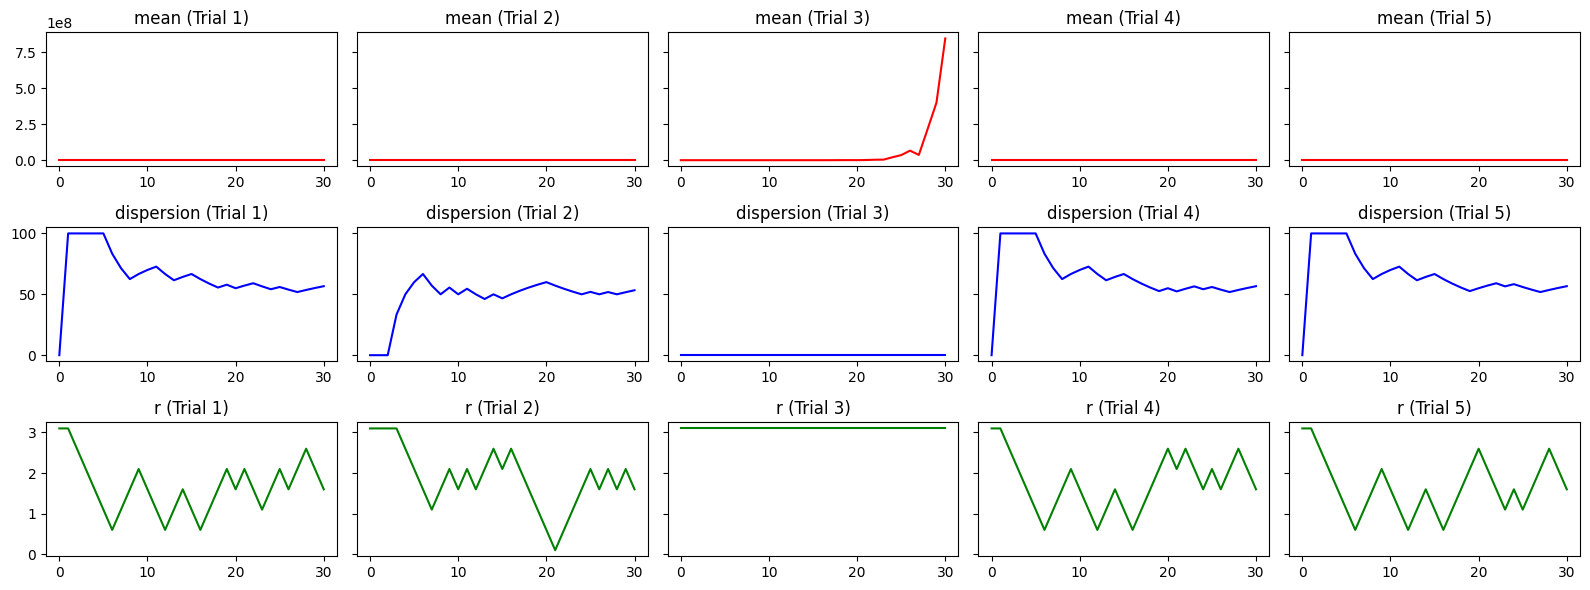

In [6]:
alpha = 4       #成功した場合のやる気の変化量を表す変数
beta = 4   #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 30
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)
kendama_change.show_ajustment_from_max(3.1, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)

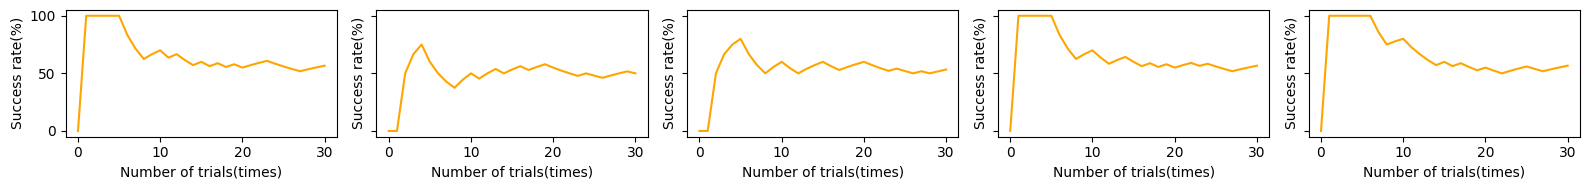

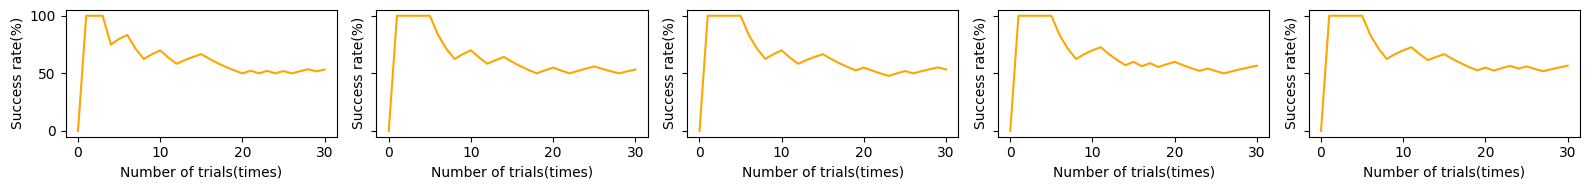

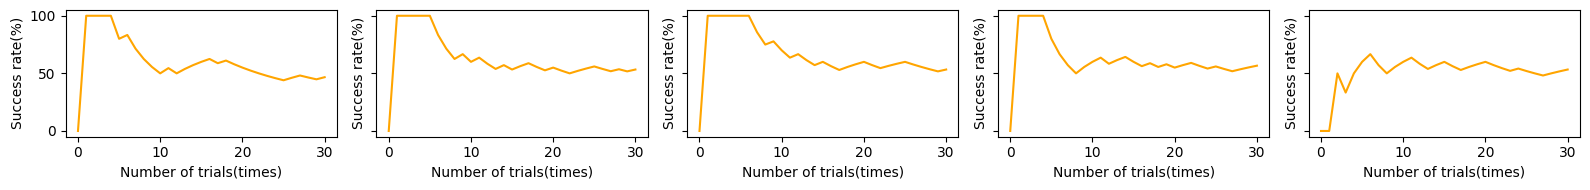

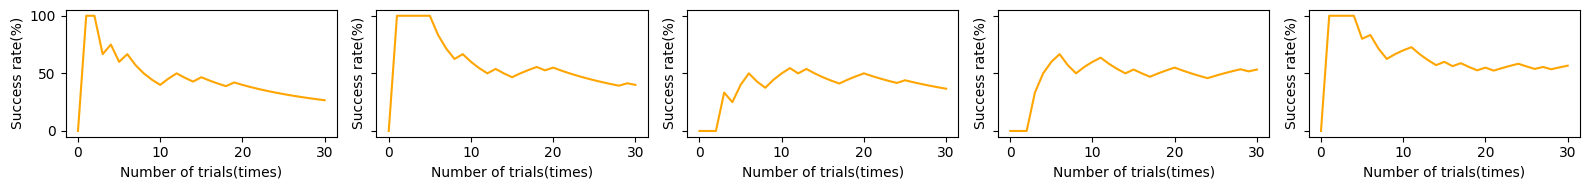

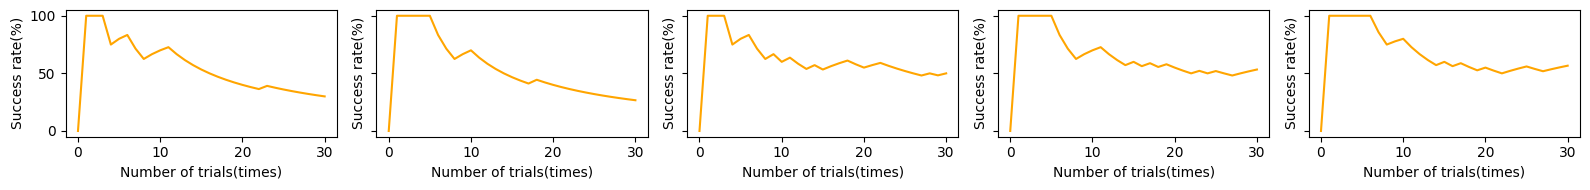

In [7]:
for i in range(1,6):
  beta = 1+i*0.1
  for j in range(1,6):
    alpha = 1+j*0.1
    kendama_change.make_ajustment_from_max_graph(3.1, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
  kendama_change.show_ajustment_from_max_graph_srate()

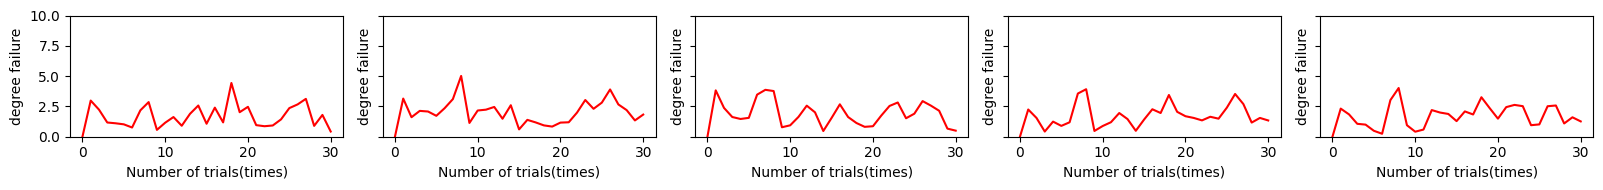

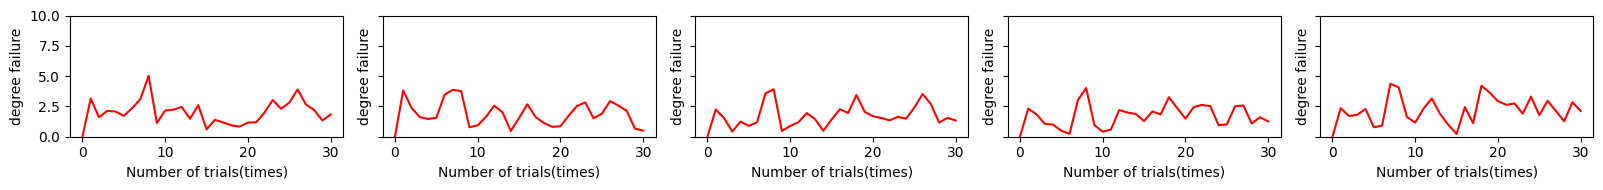

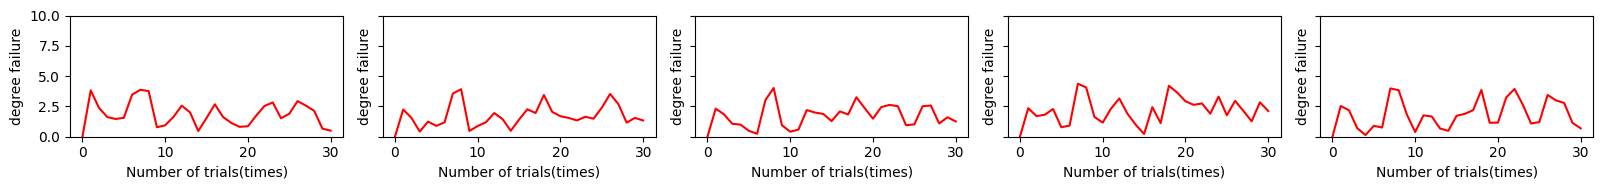

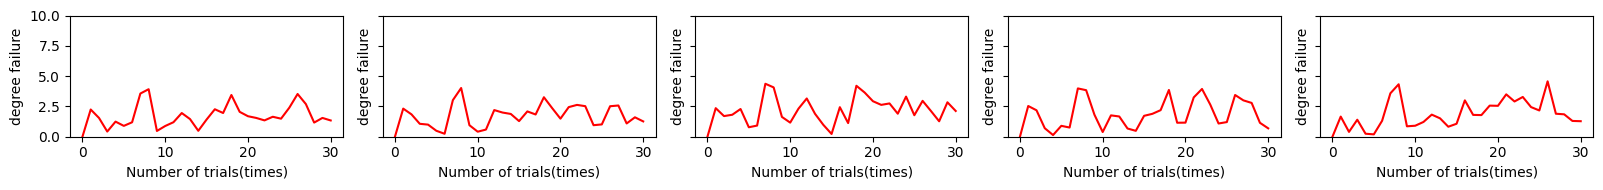

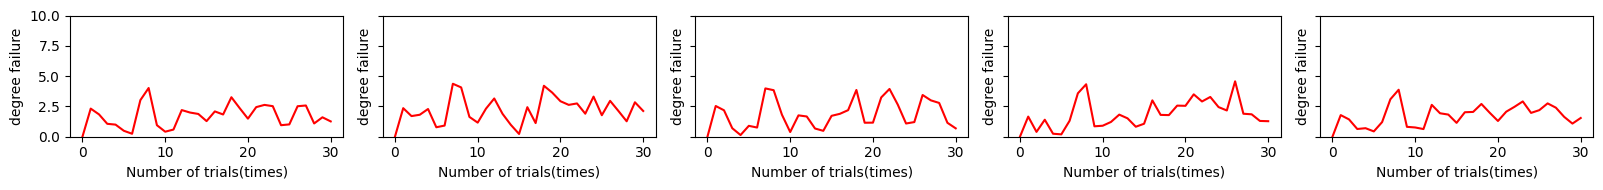

In [8]:
for i in range(0,5):
  kendama_change.show_ajustment_from_max_graph_abs(i)

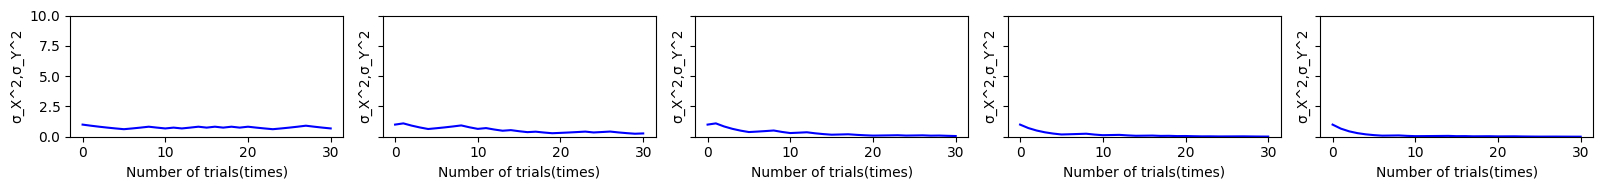

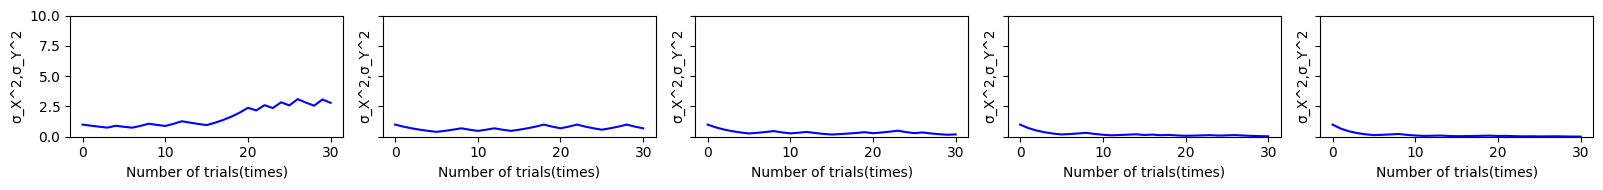

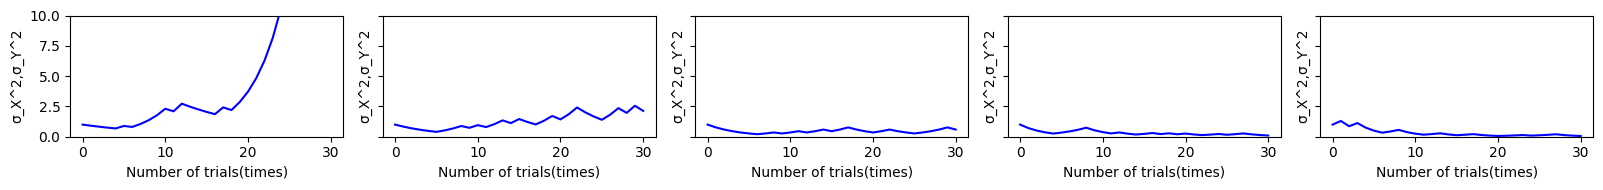

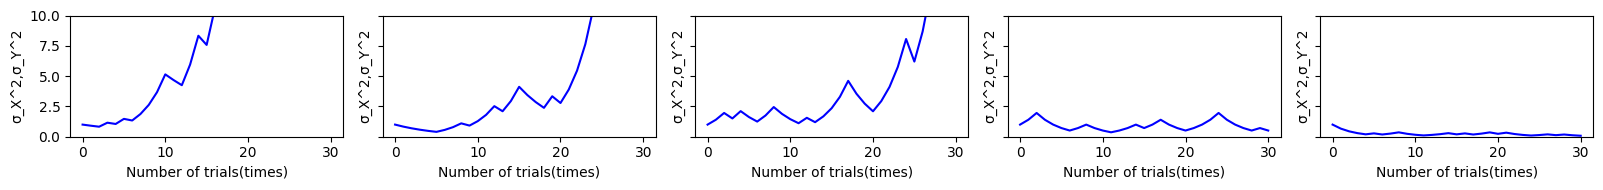

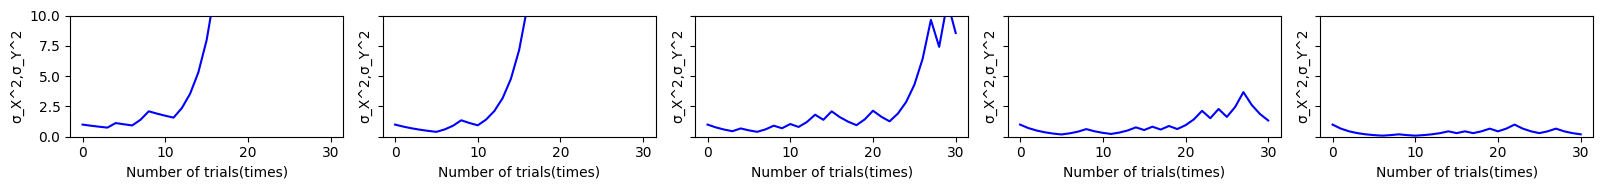

In [9]:
for i in range(0,25,5):
  kendama_change.show_ajustment_from_max_graph_dispersion(i)

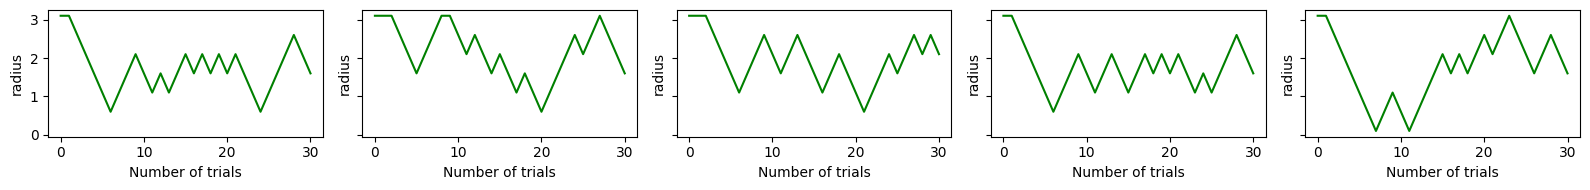

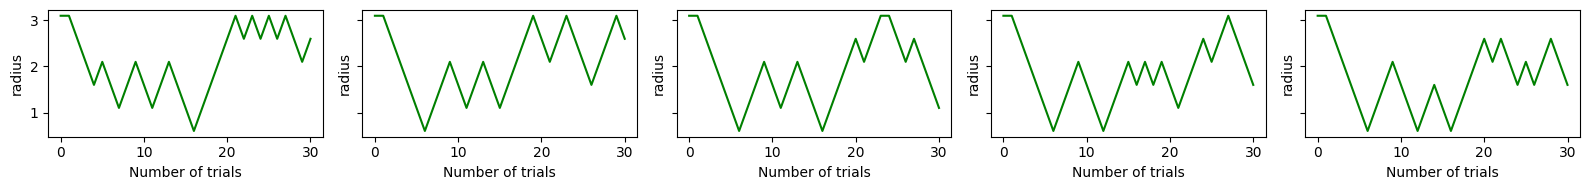

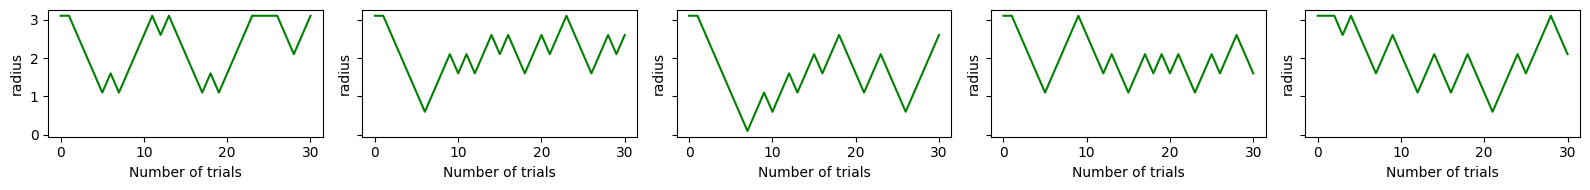

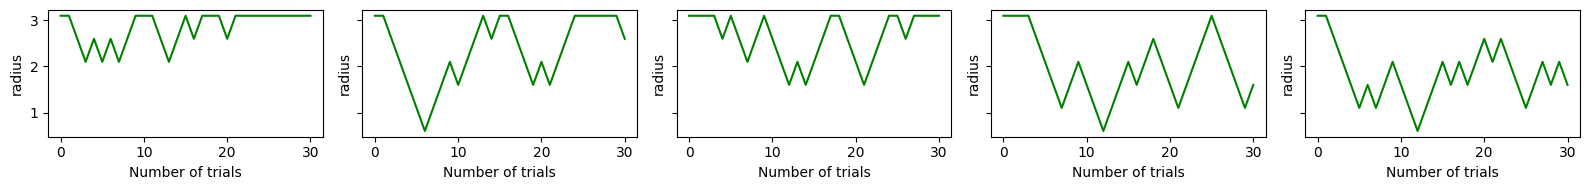

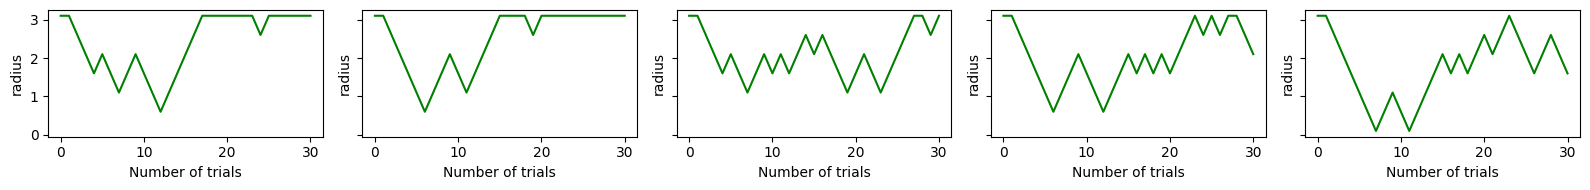

In [10]:
for i in range(0,25,5):
  kendama_change.show_ajustment_from_max_graph_R(i)

In [180]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

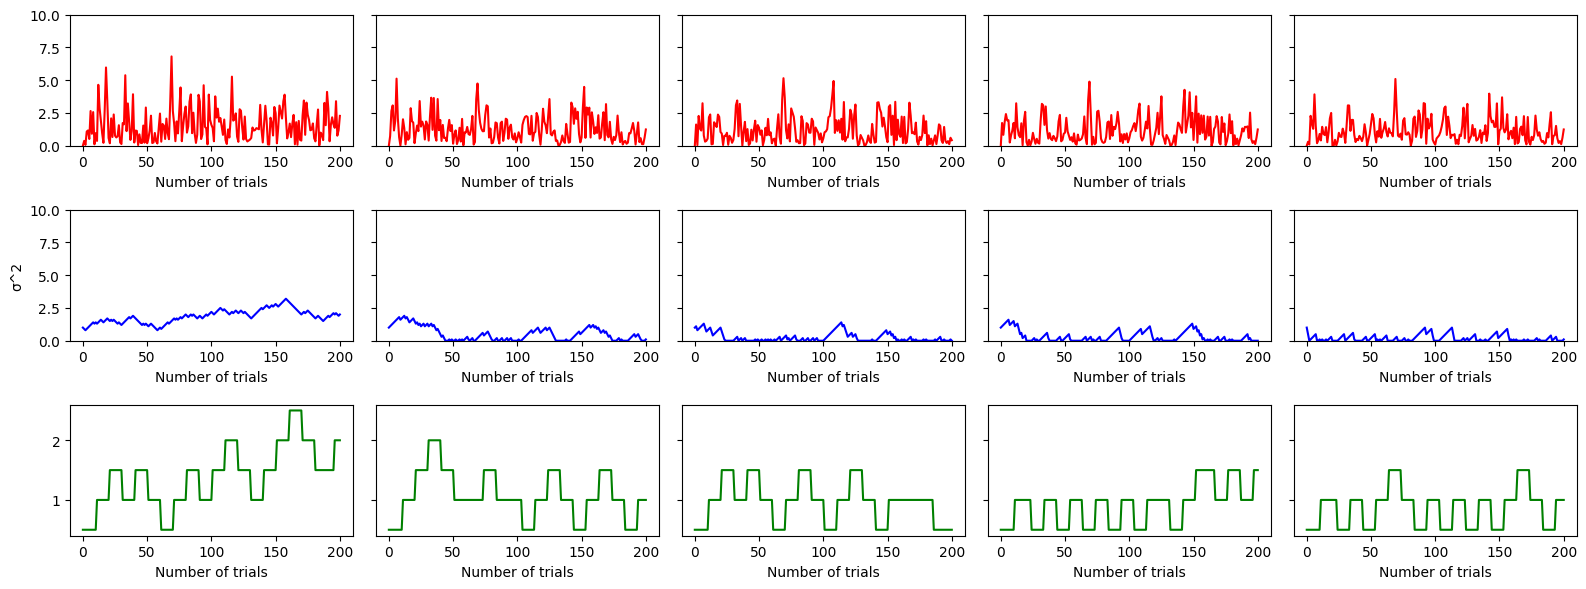

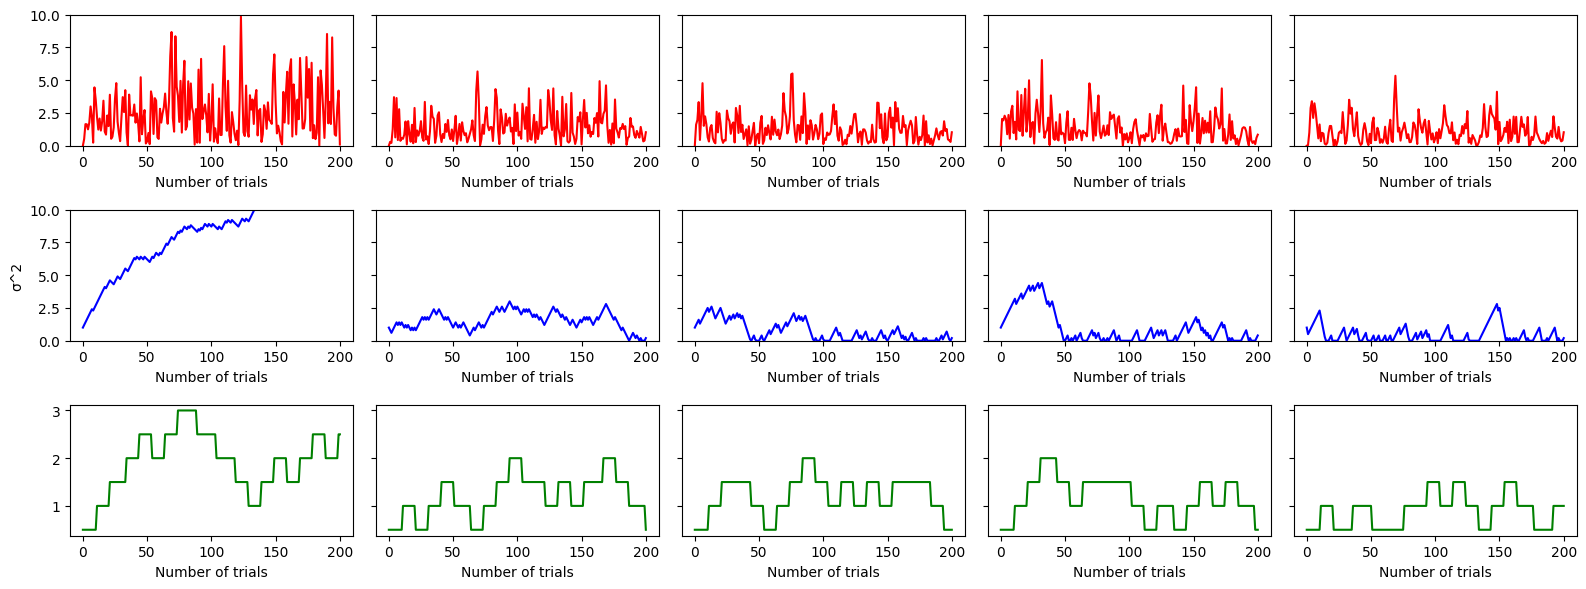

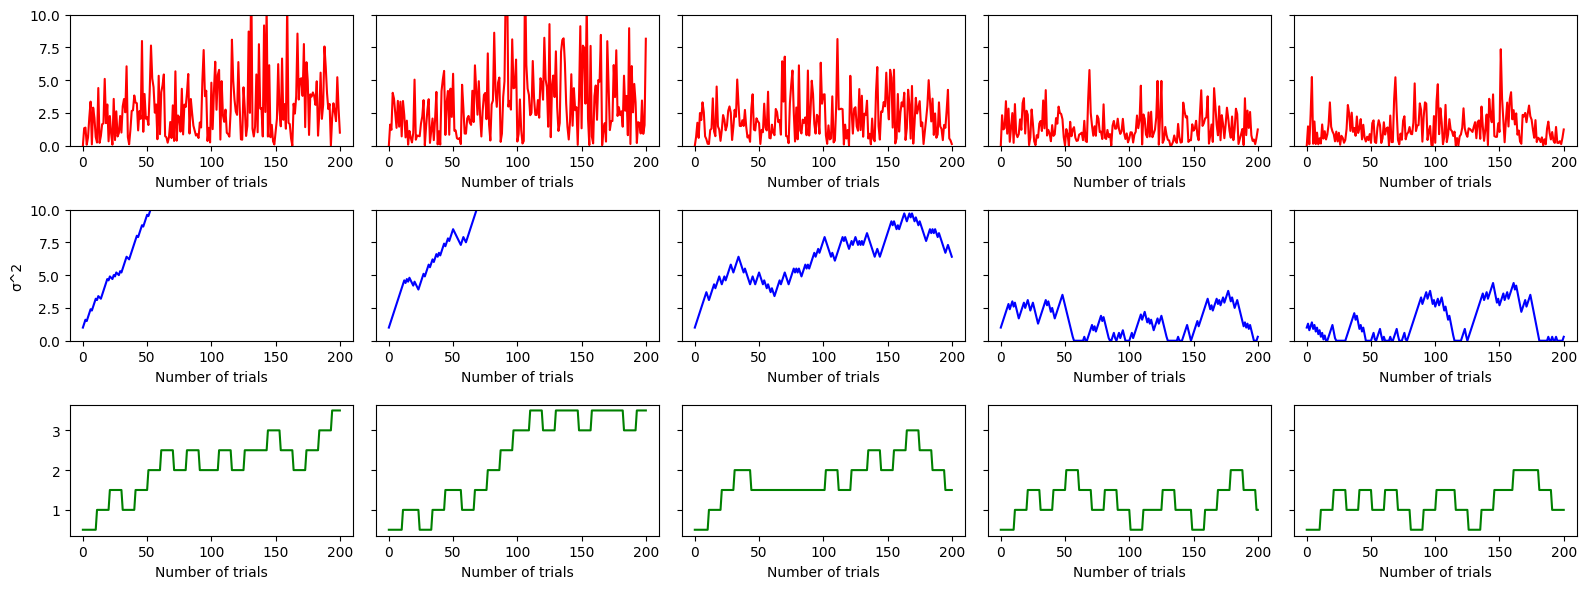

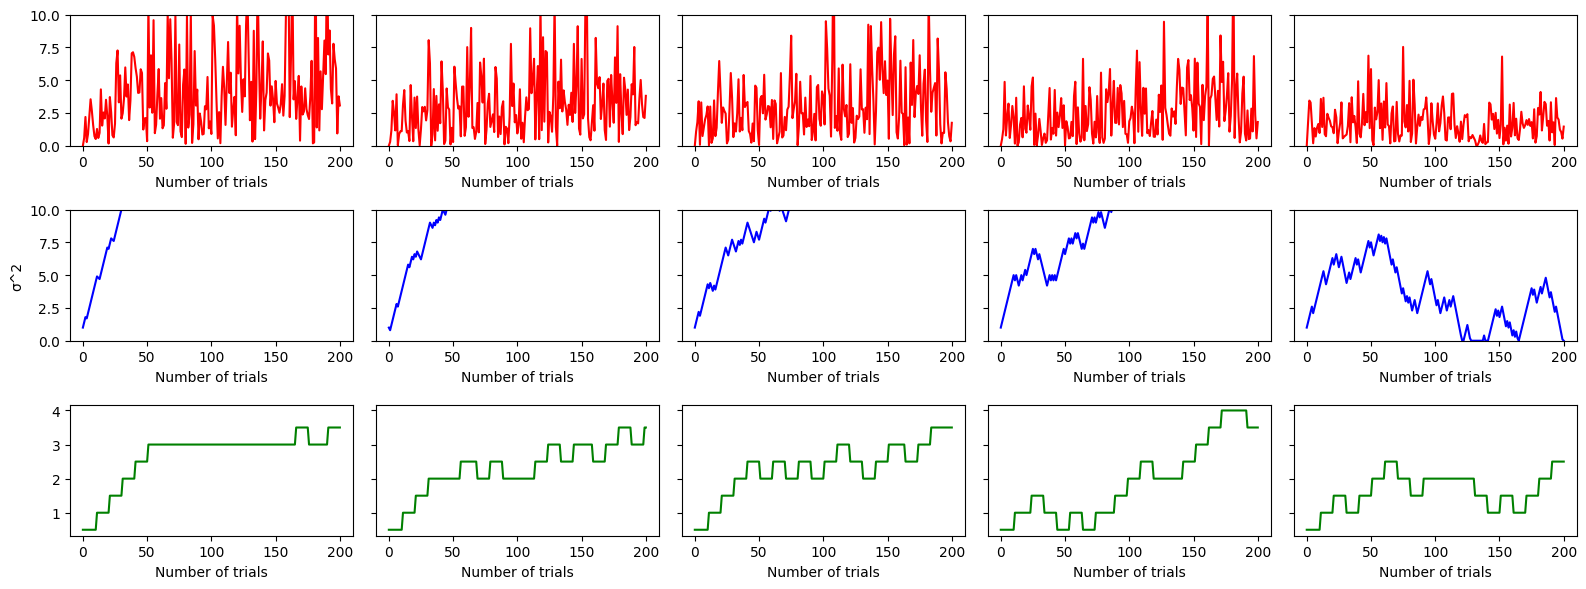

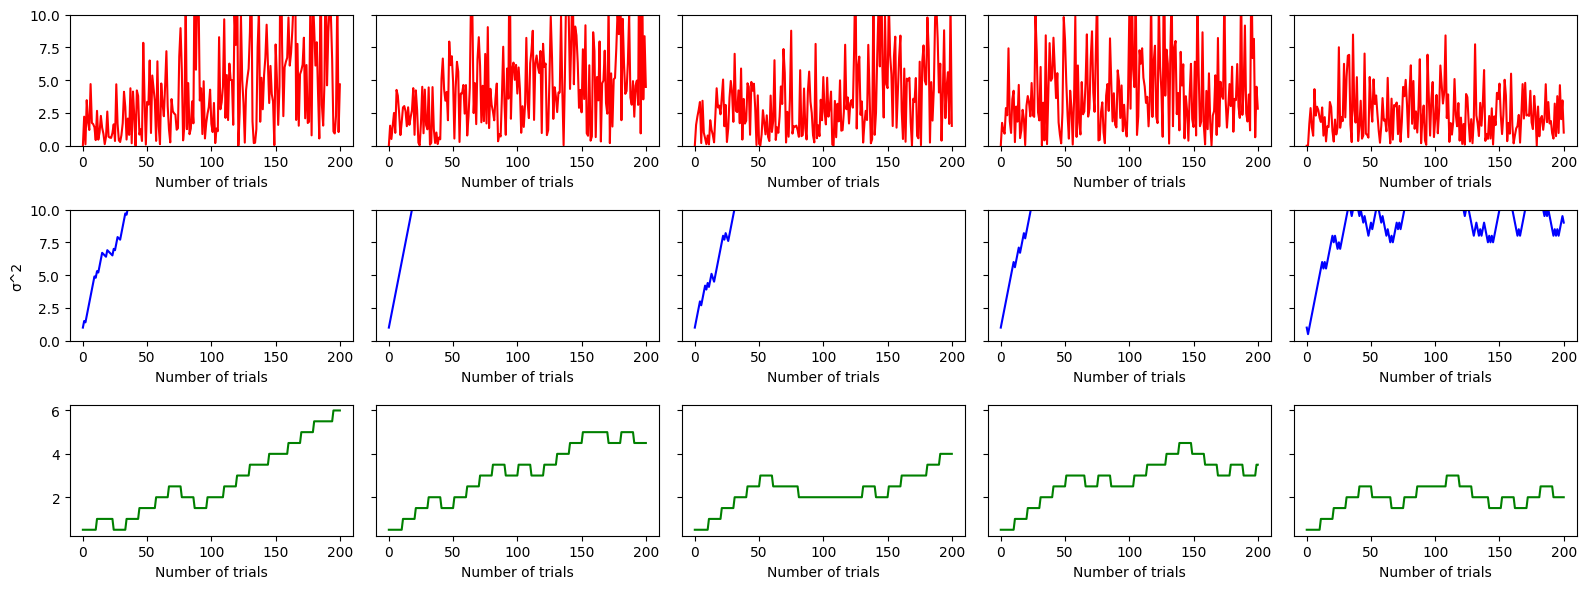

In [ ]:
for i in range(1,6):
  beta = i * 0.1
  for j in range(1,6):
    alpha = j * 0.1
    kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
  kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

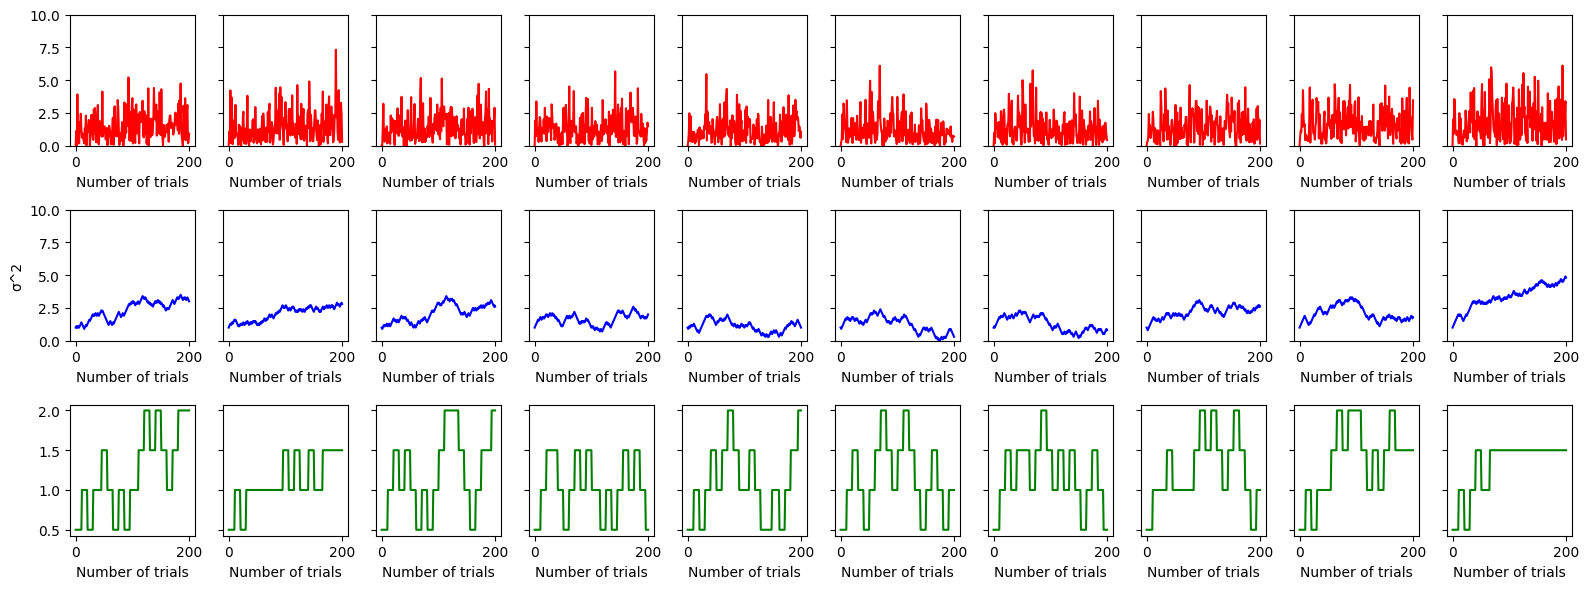

In [ ]:
for i in range(1,11):
  a = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

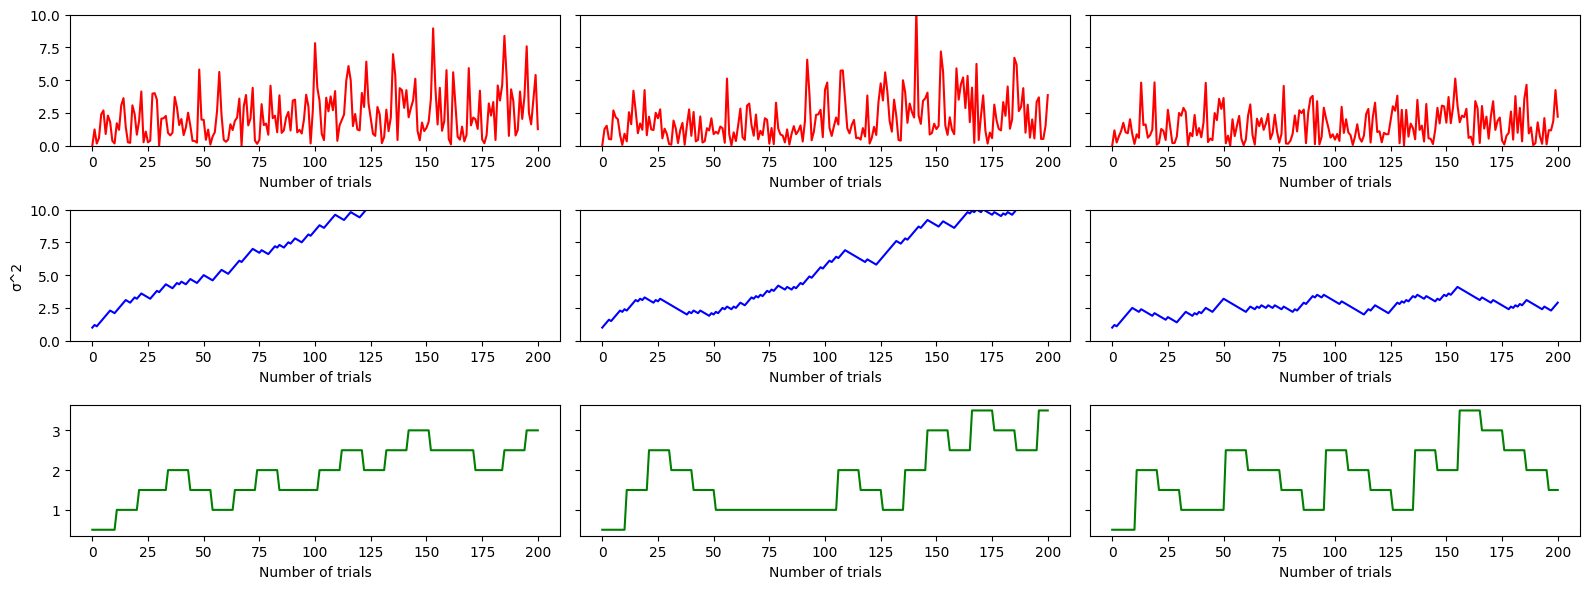

In [ ]:
beta = 0.2
alpha = 0.1
rt = 0.5
rt_alpha = 0.5
rt_beta = 1.5
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt_alpha, 1.0, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

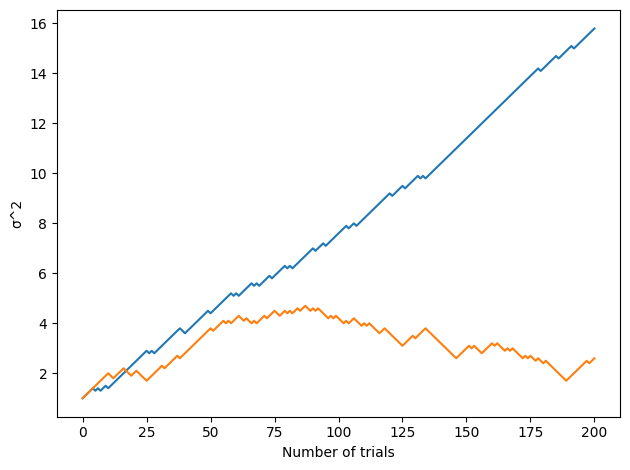

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
kendama_change.show_Comparison(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)

In [ ]:
kendama_change.show_all("trial_times = 10")

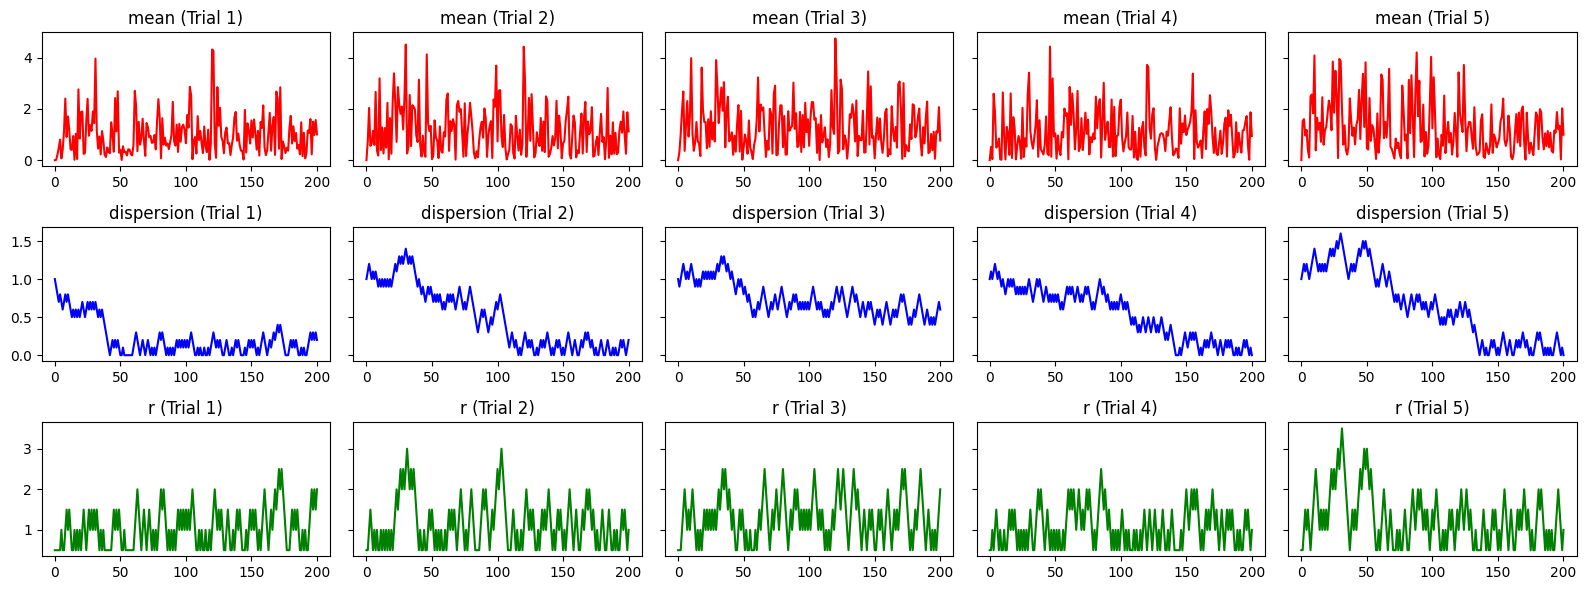

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)

kendama_change.show_ajustment_from_min(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)

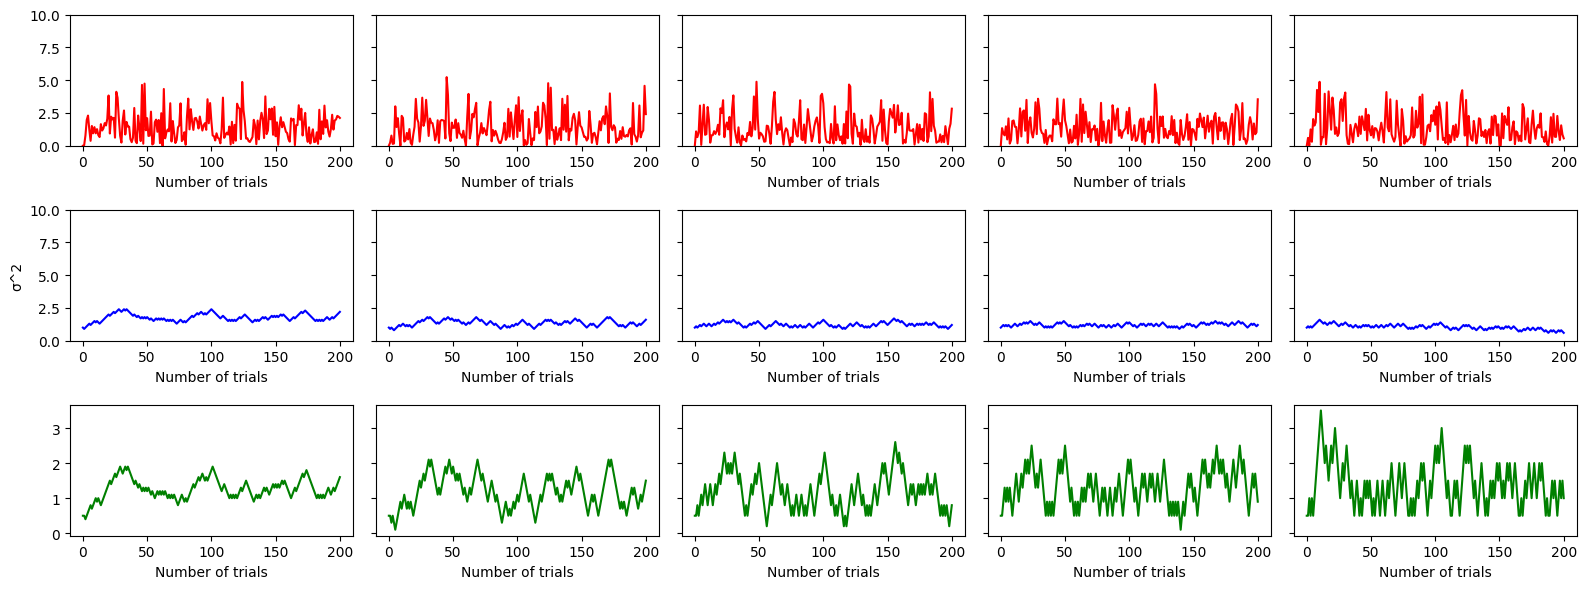

In [ ]:
for i in range(1,6):
  rt = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)

kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

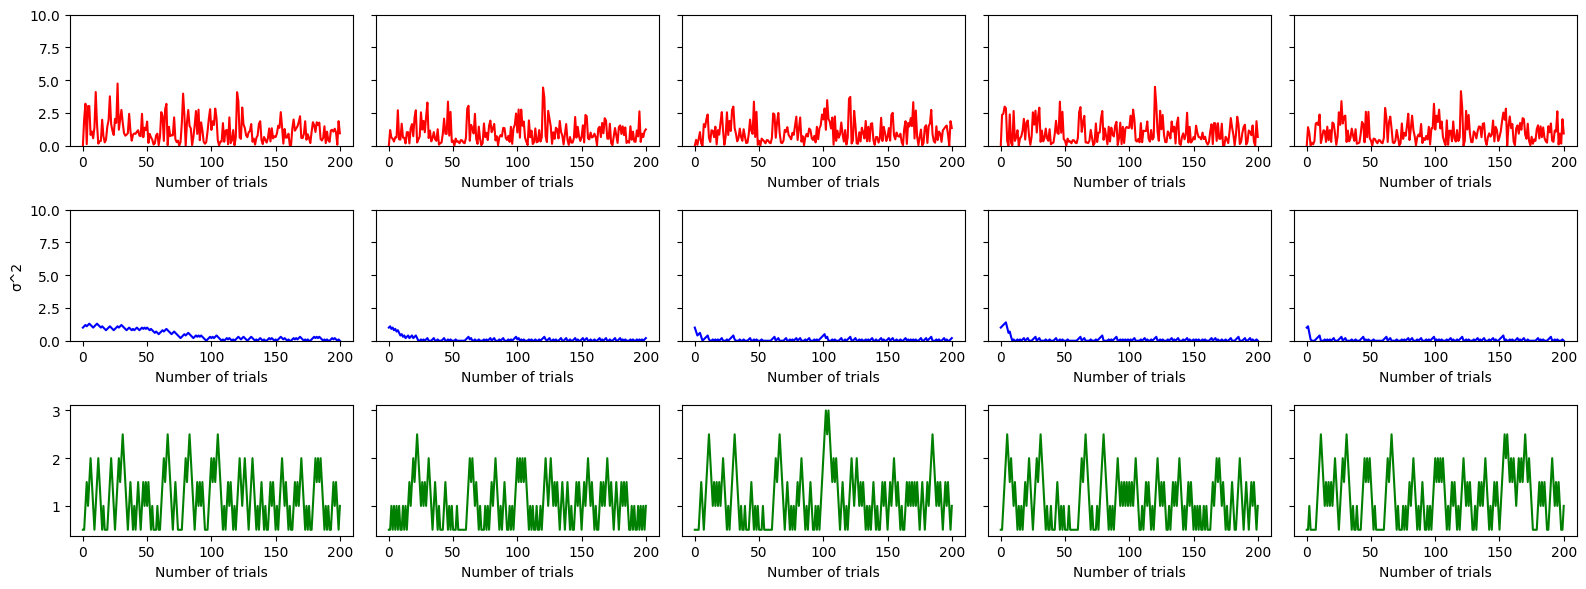

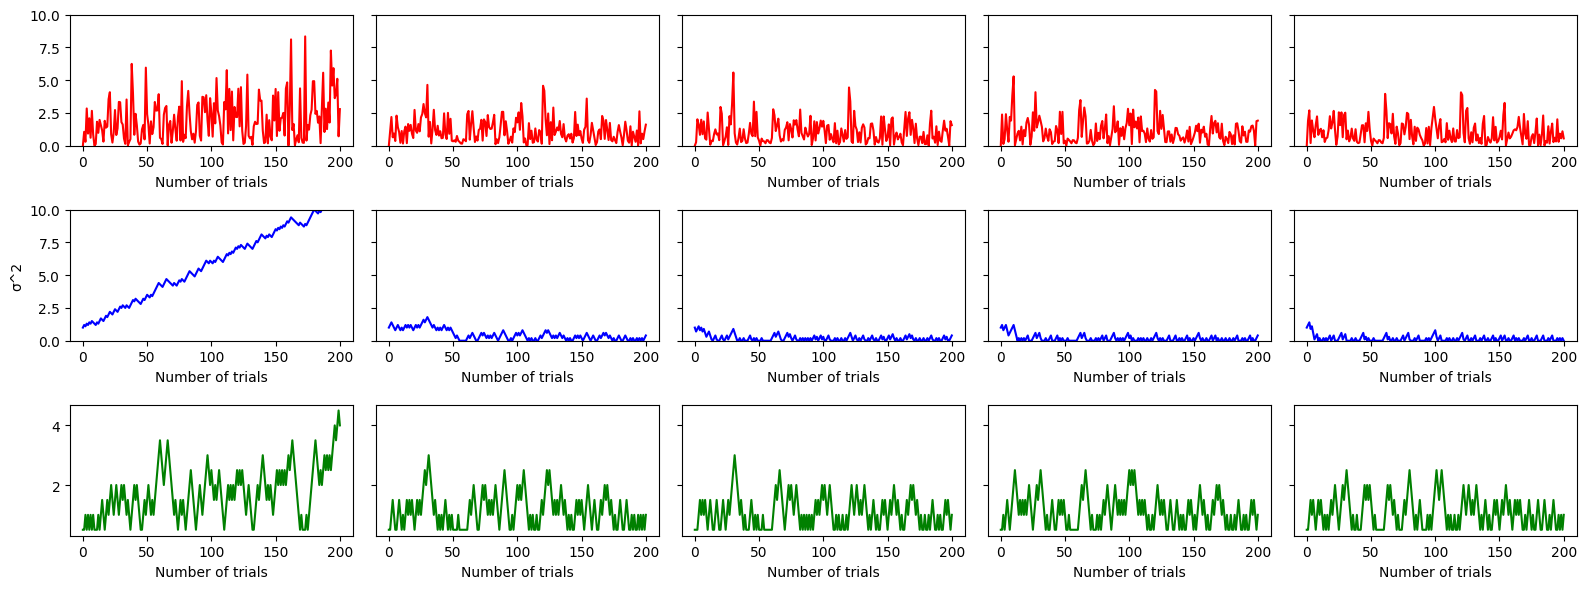

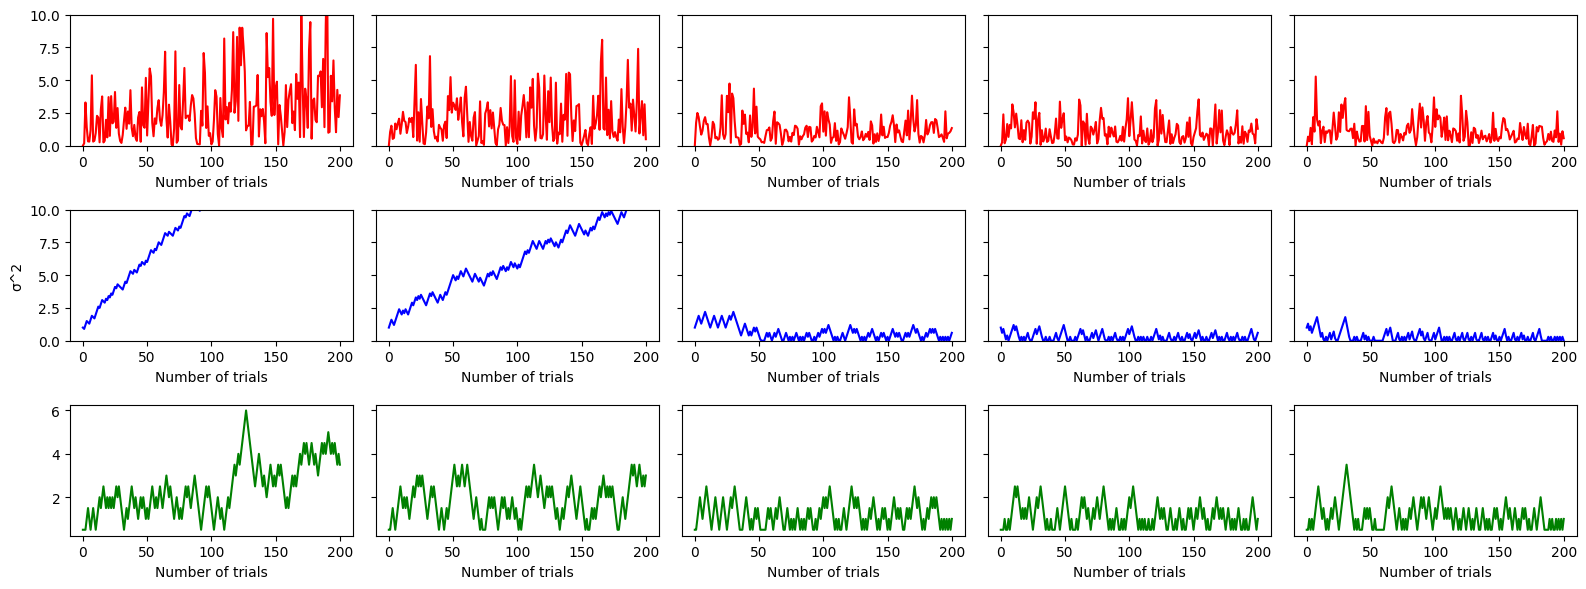

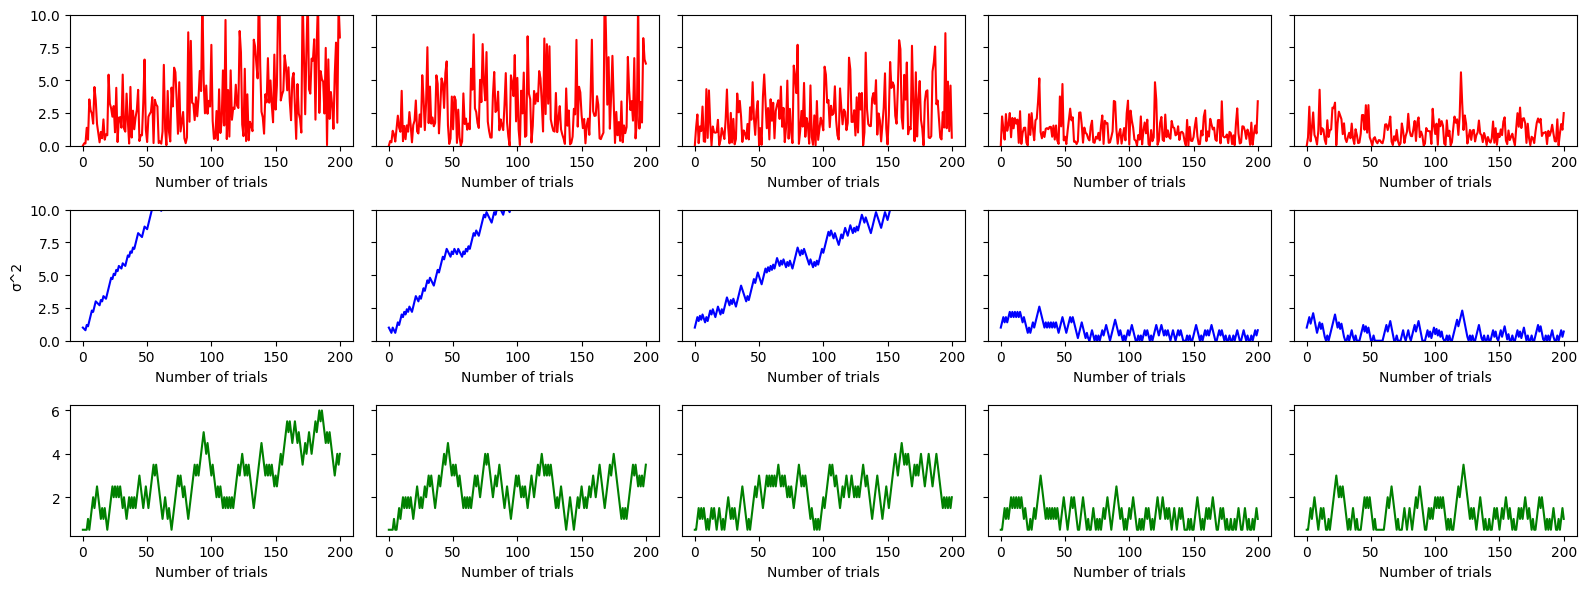

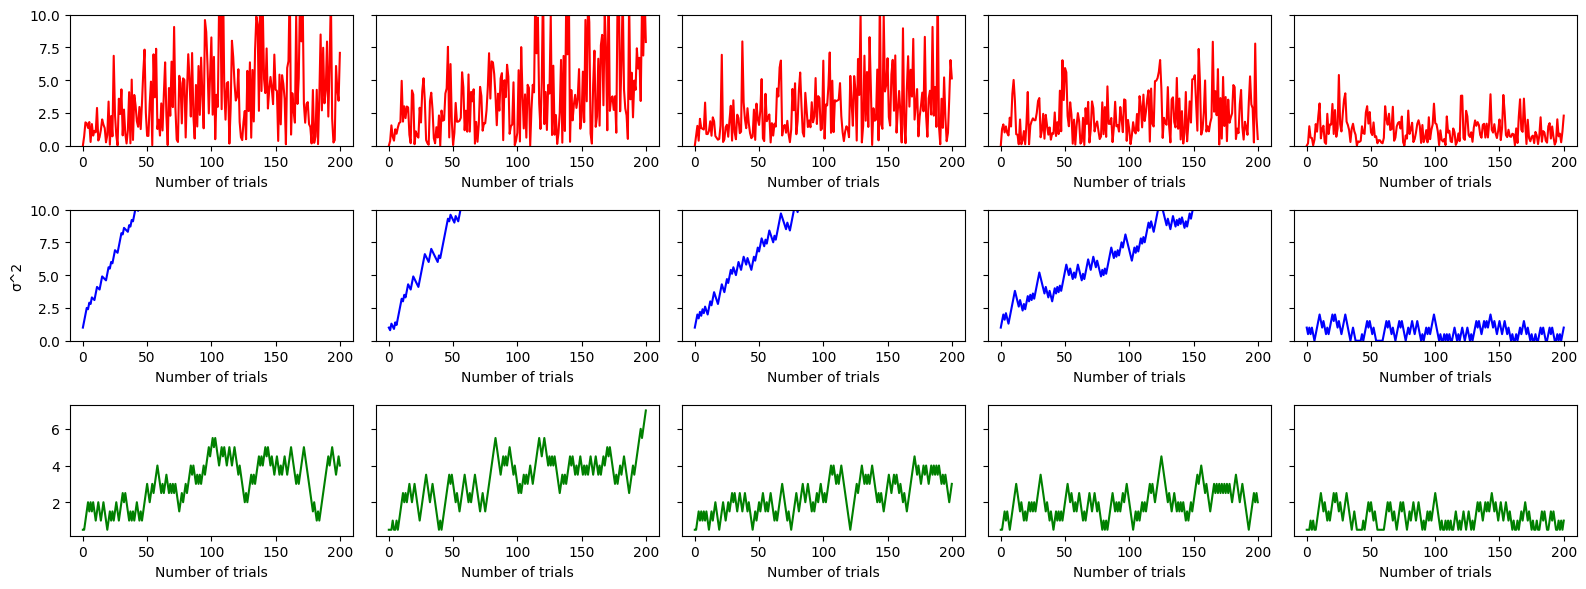

In [ ]:
for i in range(1,6):
  beta = i * 0.1
  for j in range(1,6):
    alpha = j * 0.1
    kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
  kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

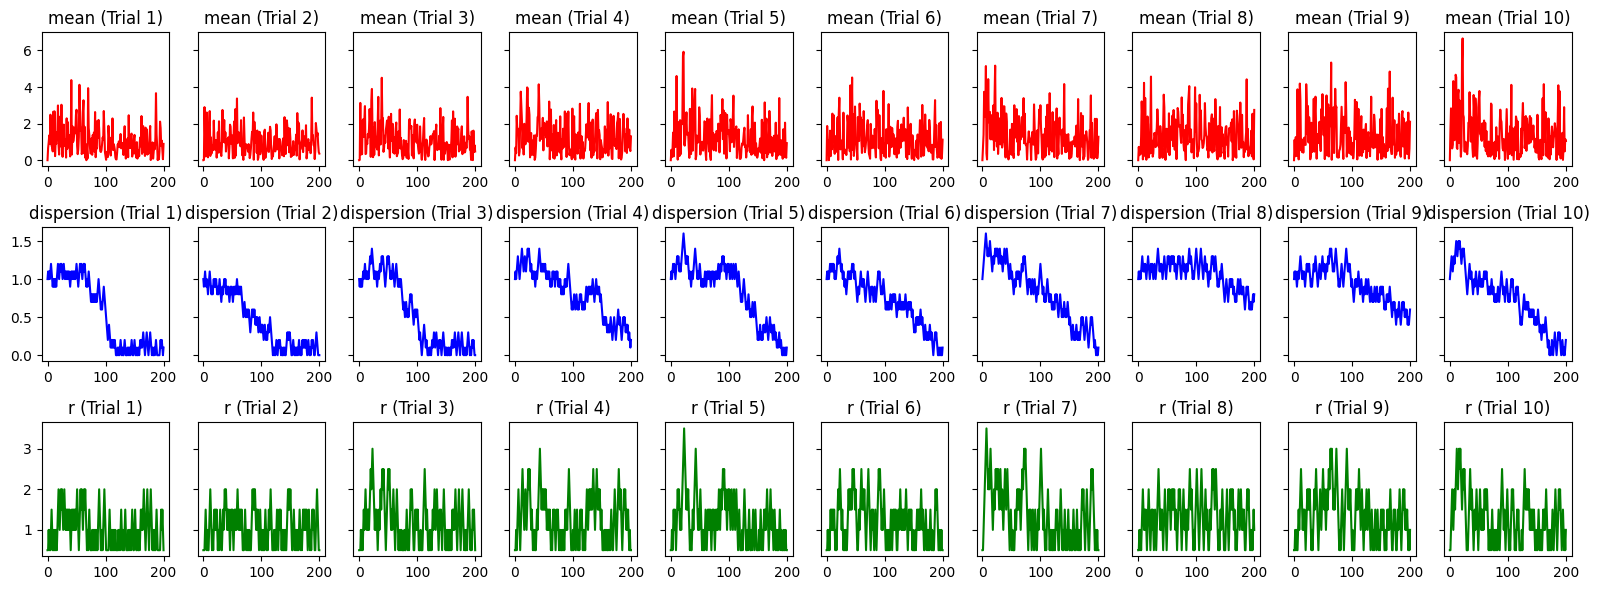

In [ ]:
for i in range(1,11):
  a = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

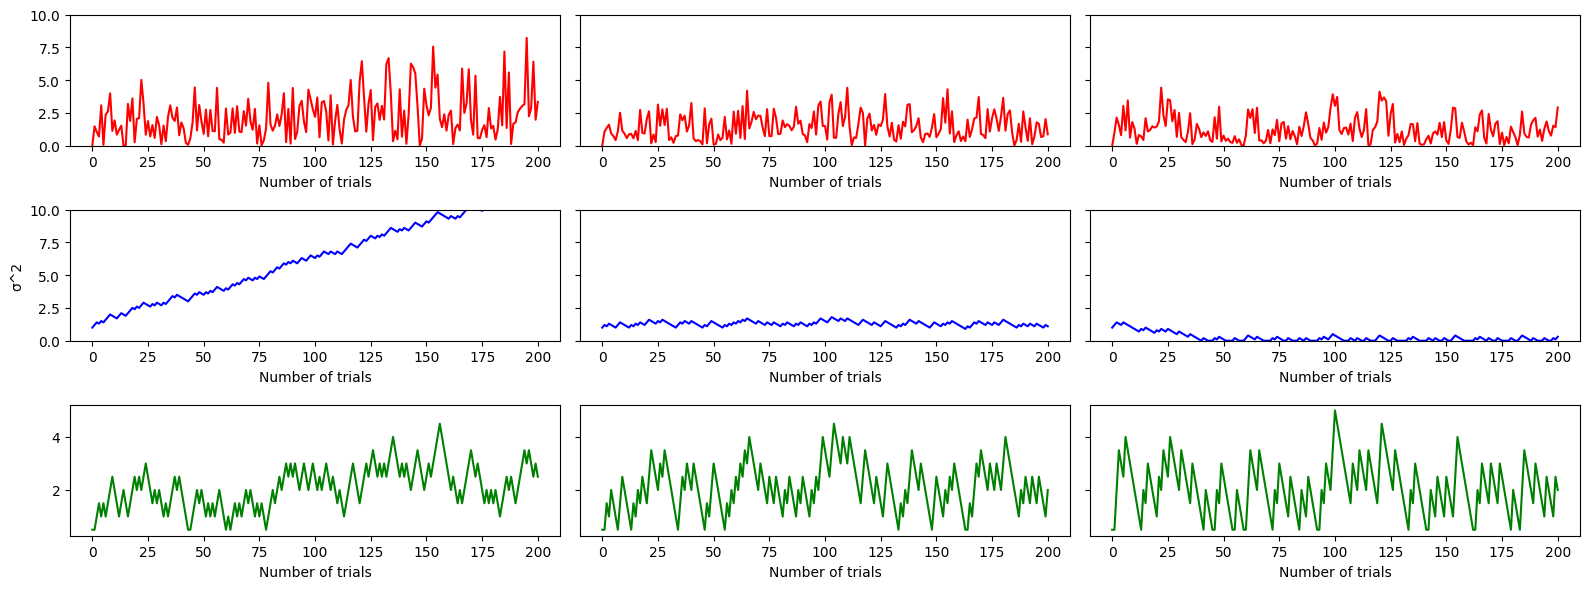

In [ ]:
beta = 0.2
alpha = 0.1
rt = 0.5
rt_alpha = 0.5
rt_beta = 1.5
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt, rt, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt_alpha, 1.0, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, rt_alpha, rt_beta, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

In [ ]:
kendama_change.show_all("trial_times = 1")